**Tabla de contenido**

- [Introducción](#Introduccion)
- [Requisitos](#Requisitos)
- [Lectura de datos](#Lectura-de-datos)
- [EDA](#EDA)
- [Preprocesamiento](#Preprocesamiento)
- [Respuestasa preguntas EDA](#Respuestasa-preguntas-EDA)
- [Feature engineering](#Feature-engineering)
- [Modelado](#Modelado)
    - [Árboles de decisión](#Arboles-de-decision)
    - [Prophet](#Prophet)
    - [Hyperparameter optimization](#hyperparameter-optimization)
        - [XGBRegressor](#XGBRegressor)
        - [RandomForestRegressor](#RandomForestRegressor)
        - [GradientBoostingRegressor](#GradientBoostingRegressor)
    - [Compentencia entre modelos](#Compentencia-entre-modelos)
    - [Feature importance](#Feature-importance)
- [Mejor modelo](#Mejor-modelo)
- [Predicciones](#Predicciones)

# Introduccion

El objetivo de este cuaderno es preparar los datos para entrenar modelos capaces de estimar la cantidad de unidades de producto enviadas a cada una de las distintas terminales de destino. En primera instancia, identificamos que se trata de un problema de series de tiempo, donde cada combinación de terminal y producto constituye una serie temporal independiente.

No siendo mas, comencemos!!!

# Requisitos

El siguiente cuaderno fue desarrollado en un entorno de anaconda con las siguientes características:

- Python 3.12.11
- pandas: 2.3.1
- numpy: 2.3.1
- os: (built-in, sin versión)
- plotly: 6.3.0
- matplotlib: 3.10.6
- seaborn: 0.13.2
- optuna: 4.5.0
- scikit-learn: 1.7.2
- xgboost: 3.0.5
- ray: 2.51.1
- prophet: 1.2.1

Comandos para instalar las librerías.

- pip install pandas==2.3.1
- pip install numpy==2.3.1
- pip install plotly==6.3.0
- pip install nbformat ipywidgets
- pip install matplotlib==3.10.6
- pip install seaborn==0.13.2
- pip install optuna==4.5.0
- pip install scikit-learn==1.7.2
- pip install xgboost==3.0.5
- pip install ray==2.51.1
- pip install prophet==1.2.1


# Lectura de datos

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import os

import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)

import ray
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from itertools import product
import warnings
warnings.filterwarnings("ignore")


project_root = next(p for p in Path.cwd().parents if (p / 'data').exists()) 
file_path = lambda file : os.path.join(project_root,'data',file)
data_entregas = pd.read_csv(file_path('DataSet_Entregas.csv'))
data_entregas.head()

,ID,Ciudad_Origen,Ciudad_Destino,Terminal_Origen,Terminal_Destino,Producto,Cliente,Fecha_Recogida,Fecha_Entrega,Dias_Ofrecidos,Dias_Transcurridos,Peso,Peso_Volumen,Unidades
0,11,Bucaramanga (Stder),San Juan Del Cesar (Guaj),6. Bucaramanga,20. Valledupar,Paquetería,AB-JABEEHEBI,2023-12-26,2024-01-01,3,4,1.0,1.00,1
1,36,Cartagena (Bol),Santa Marta (Mg/Lena),9. Turbaco,22. Santa Marta,Paquetería,AB-IAFAADGCG,2023-12-29,2024-01-02,1,2,1.0,1.00,1
2,43,Cerrito (Stder),Bucaramanga (Stder),6. Bucaramanga,6. Bucaramanga,Paquetería,AB-DFCHBFHHB,2023-12-30,2024-01-02,1,1,2.0,0.01,1
3,48,Bucaramanga (Stder),Monteria (Cord),6. Bucaramanga,14. Monteria,Paquetería,AH-JABDDDAAH,2023-12-26,2024-01-02,2,5,1.0,0.40,1
4,49,Pereira (Rs),La Hormiga - Valle Guamuez (P/Mayo),4. Pereira,23. Neiva,Paquetería,AB-DFCHBFHHB,2023-12-26,2024-01-02,5,5,2.0,0.01,1


# EDA

El propósito principal del análisis exploratorio de datos es comprender el estado y las características de la información antes de decidir qué técnicas de ciencia de datos o machine learning aplicar. Eso implica organizar los datos, conocer su contenido, identificar las variables más relevantes y analizar como se relacionan entre sí, detectar patrones, evaluar la presencia de datos faltantes y valores atípicos y finalmente extraer conclusiones apartir de este proceso.

En general el EDA busca obtener una visión de cómo estan los datos, y para esto realizaremos las siguientes etapas:

- Consultar la cantidad de registros y columnas en la base de datos.
- Consultar los estadisticos básicos del dataframe
- Consultar los valores faltantes
- Evaluar la presencia de atípicos

Estos puntos analizados nos dan paso al preprocesamiento de los datos, con lo cual buscamos obtener una matriz limpia para responder las preguntas de investigación para el análisis exploratorio.

1. Cuáles son las terminales donde se hacen más envios? 

2. Cuáles son los productos más frecuentados.

In [3]:
print(f"la cantidad de resgistros que tiene el dataframe son: {data_entregas.shape[0]}")
print(f"La cantidad de características son: {data_entregas.shape[1]}")

la cantidad de resgistros que tiene el dataframe son: 5158113
La cantidad de características son: 14


Podemos observar que el dataset que contiene las entregas está compuesto por `14 columnas` (características) y 5158113 registros. Veamos los estadísticos básicos de este dataset.

In [4]:
pd.set_option('display.float_format', '{:.2f}'.format)
data_entregas.describe()

,ID,Dias_Ofrecidos,Dias_Transcurridos,Peso,Peso_Volumen,Unidades
count,5158113.00,5158113.00,5158113.00,5158113.00,5158113.00,5158113.00
mean,2579057.00,2.14,2.93,8.84,14.64,1.21
std,1489019.11,1.33,4.85,142.38,88.67,5.77
min,1.00,1.00,-1.00,0.01,0.00,1.00
25%,1289529.00,1.00,1.00,1.00,0.57,1.00
50%,2579057.00,2.00,2.00,1.00,1.00,1.00
75%,3868585.00,3.00,3.00,7.00,12.00,1.00
max,5158113.00,17.00,724.00,249615.00,32986.80,1817.00


Ok. Puedo observar que en la variable **Dias_Transcurridos** el valor mínimo es un valor negativo (-1.00) y el valor máximo de la variable `Dias_transcurridos` es de 724.00, indicando muy posiblemente la presencia de valores atípicos. En el caso de la variable `Peso_Volumen`, esta presenta una desviación estandar de 88.67, indicando que los productos varian mucho de Peso_volumen.

Veamos si este dataset tiene datos faltantes.

In [5]:
data_entregas.isnull().sum()

ID                    0
Ciudad_Origen         0
Ciudad_Destino        0
Terminal_Origen       0
Terminal_Destino      0
Producto              0
Cliente               0
Fecha_Recogida        0
Fecha_Entrega         0
Dias_Ofrecidos        0
Dias_Transcurridos    0
Peso                  0
Peso_Volumen          0
Unidades              0
dtype: int64

Perfecto!!!

No tenemos que preocuparnos por los datos faltantes. Veamos si hay valores duplicados

In [6]:
print(f"Duplicados (sin contar la primera aparición): {data_entregas.duplicated().sum()}")

Duplicados (sin contar la primera aparición): 0


Esto es positivo; no hay registros duplicados. Ahora, examinemos qué tipos de datos contiene el dataframe.

In [7]:
data_entregas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5158113 entries, 0 to 5158112
Data columns (total 14 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ID                  int64  
 1   Ciudad_Origen       object 
 2   Ciudad_Destino      object 
 3   Terminal_Origen     object 
 4   Terminal_Destino    object 
 5   Producto            object 
 6   Cliente             object 
 7   Fecha_Recogida      object 
 8   Fecha_Entrega       object 
 9   Dias_Ofrecidos      int64  
 10  Dias_Transcurridos  int64  
 11  Peso                float64
 12  Peso_Volumen        float64
 13  Unidades            int64  
dtypes: float64(2), int64(4), object(8)
memory usage: 550.9+ MB


Ok, podemos observar que en este dataset tenemos las siguientes variables.

`Variables numéricas (6)`

- ID, Dias_Ofrecidos, Dias_Transcurridos, Peso, Peso_Volumen, Unidades.

`Variables categóricas (6)`

- Ciudad_Origen, Ciudad_Destino, Terminal_Origen, Terminal_Destino, Producto, Cliente.

`Variables temporales (2)`

- Fecha_Recogida, Fecha_Entrega 

En este caso, las variables que representan fechas deben ser tranformadas a Datetime, para poder trabajarlas de la forma adecuada.

# Preprocesamiento

Dado que el propósito de este cuaderno es preparar los datos para entrenar modelos que puedan estimar la cantidad de unidades de producto enviadas a cada una de las distintas terminales de destino, procederemos a:

- Verificar cuantas Terminales de destino hay en el dataset.
- Eliminar los registros que en la variable **"Días_Transcurridos"** (días hábiles entre la fecha de recogida y la fecha de entrega) sean negativos, pues un valor negativo implicaría que la fecha de entrega es anterior a la fecha de recogida, lo cual no es posible en el proceso real.
- Convertir la fecha de entrega a formato datetime.

In [8]:
data_entregas['Terminal_Destino'].unique()

array(['20. Valledupar', '22. Santa Marta', '6. Bucaramanga',
       '14. Monteria', '23. Neiva', '12. Cucuta', '4. Pereira',
       '13. Manizales', '29. Tunja', '21. Villavicencio', '24. Rionegro',
       '8. Sincelejo', '5. Ibague', '30. Calarca', '31. Copacabana',
       '32. Aguachica', '19. Yopal', '28. Flandes', '11. Pasto',
       '9. Turbaco', '27. Apartado', '0. Sin Terminal', '17. Popayan',
       '39. Pitalito', '34. Florencia', '35. Barrancabermeja',
       '37. Fusagasuga', '15. Buenaventura', '36. Riohacha',
       '38. La Ceja'], dtype=object)

En total existen 30 terminales de destino. Eliminemos los registros negativos en la columna **"Días_Transcurridos"** y veamos el total de datos conservados y eliminados

In [9]:
clean_data = data_entregas[
    (data_entregas['Dias_Transcurridos'] >= 0) 
].copy()

In [10]:
# Datos
filas_eliminadas = len(data_entregas) - len(clean_data)
porcentaje_eliminado = (filas_eliminadas / len(data_entregas)) * 100
porcentaje_total = 100 - porcentaje_eliminado

porcentajes = [porcentaje_total, porcentaje_eliminado]
categorias = ['Datos conservados', 'Datos eliminados']
colores = ['#191970', '#FF5733']

# Crear el gráfico circular
fig = go.Figure(data=[go.Pie(
    labels=categorias,
    values=porcentajes,
    textinfo='percent+label',
    marker=dict(colors=colores),
    hole=0.3,  
    pull=[0.05, 0.05]  # Para separar las secciones
)])

# Personalizar el diseño
fig.update_layout(
    title_text='Datos conservados y eliminados',
    title_font_size=14,
    title_font_weight='bold',
    font=dict(color='black'),  
    paper_bgcolor='white', 
    plot_bgcolor='white',  
    width=600,  
    height=600  
)
fig.show()

Excelente, ahora contamos con dos DataFrames:

- clean_data: DataFrame que ha sido depurado.
- data_entregas: DataFrame que incluye todos los valores.

Y vamos a convertir la columna **Fecha_Entrega** a formato datetime

In [11]:
clean_data = clean_data[['Terminal_Destino','Producto','Fecha_Entrega','Unidades']]
clean_data['Fecha_Entrega'] = pd.to_datetime(clean_data['Fecha_Entrega'],format='%Y-%m-%d')
clean_data = clean_data.sort_values(by=['Terminal_Destino', 'Fecha_Entrega'])

# Respuestasa preguntas EDA

Ahora que hemos comprendido la estructura y características de los datos, es momento de abordar las preguntas de investigación planteadas para este análisis exploratorio.

1. ¿Cuáles son las terminales donde se hacen más envios?
2. ¿Cuáles son los productos más enviados a estas terminales?

Bueno, antes de dar respuesta a esta pregunta, definamos la función que gráficará los resultados que vamos a obtener.

In [15]:
def crear_barplot_personalizado(df, x, y, color,decimales ,titulo=''):
    """
    Crea un gráfico de barras personalizado usando Plotly.

    Parámetros:
    - df: DataFrame de entrada
    - x: columna para el eje X
    - y: columna para el eje Y
    - color: columna para agrupar por color
    - titulo: título opcional del gráfico
    """
    bar_fig = px.bar(
        df,
        x=x,
        y=y,
        color=color,
        barmode='group',
        text=y,
        labels={x: ' ', y: 'Porcentaje'},
    )

    # Personalización del gráfico
    bar_fig.update_traces(textposition='outside',texttemplate=decimales,
                          textfont=dict(family='Arial', size=12, color='black', weight='bold'))
    bar_fig.update_layout(
        plot_bgcolor='white',
        paper_bgcolor='white',
        title=titulo,
        title_x=0.5,
        title_font=dict(size=18, family='Arial', color='black'),

        xaxis=dict(
            title_font=dict(size=12, family='Arial', color='black'),
            tickfont=dict(size=7, family='Arial', color='black', weight='bold'),
            showgrid=True,
            gridcolor='lightgrey',
            zerolinecolor='lightgrey',
        ),
        yaxis=dict(
            title='',
            tickfont=dict(size=12, family='Arial', color='black', weight='bold'),
            autorange=True,
            ticklen=10,
            showline=True,
            linecolor='black',
            automargin=True,
            ticksuffix='   ',
        ),
        hoverlabel=dict(
            bgcolor='white',
            font_size=12,
            font_family='Arial'
        ),
        showlegend=True,
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=1.05,
            xanchor='center',
            x=0.5,
            font=dict(size=10)
        ),
        bargap=0.2,
    )

    return bar_fig

Ahora si, ¿Cuáles son las terminales donde se hacen más envios?

In [16]:
mas_envios = clean_data.groupby(by=['Terminal_Destino']).agg(
    sum_unidades = ('Unidades','sum')
).reset_index()

mas_envios['Porcentaje'] = (mas_envios['sum_unidades']/mas_envios['sum_unidades'].sum())*100
mas_envios = mas_envios.sort_values(
    by='Porcentaje',  # Columna por la que ordenar
    ascending=False   # Orden descendente (de mayor a menor)
).reset_index(drop=True) 
fig = crear_barplot_personalizado(mas_envios, 
                                  x='Terminal_Destino', 
                                  y='Porcentaje', 
                                  color='Porcentaje',
                                  decimales ='%{y:.2f}%',
                                  titulo='Porcentaje de unidades envidas a terminales de destino')
fig.show()

Ok, podemos observar que se realizan muchos envios a las terminales de Bucaramanga, Turbaco y Pereira. 

Pero, Cuáles son los productos más enviados?

In [17]:
mas_enviados = clean_data.groupby(by=['Terminal_Destino','Producto']).agg(
    sum_productos = ('Unidades','sum')
).reset_index()
mas_enviados['Porcentaje'] = (mas_enviados['sum_productos']/mas_enviados['sum_productos'].sum())*100

mas_enviados = mas_enviados.sort_values(
    by='Porcentaje',  # Columna por la que ordenar
    ascending=False   # Orden descendente (de mayor a menor)
).reset_index(drop=True) 

fig = crear_barplot_personalizado(mas_enviados, 
                                  x='Terminal_Destino', 
                                  y='Porcentaje', 
                                  color='Producto',
                                  decimales ='%{y:.1f}%',
                                  titulo='')
fig.show()

En general, en todas las terminales predominan los envíos de paquetería y mercancía. Sin embargo, la terminal de Pasto presenta un comportamiento distinto, ya que ha recibido una mayor cantidad de productos del tipo mercancía.

# Feature engineering

Ahora que contamos con una visión general de los datos, podemos codificar la variable categórica Producto como una variable ordinal. En las gráficas anteriores observamos que esta variable presenta una jerarquía intrínseca: predominan los productos de Paquetería, seguidos por Mercancía y, finalmente, Mercancía XL. Esto nos permite asignar valores ordinales de 3 a 1 respetando dicho orden.

In [18]:
dict_producto ={
    'Paquetería':3,
    'Mercancía':2,
    'Mercancía XL':1
}

clean_data['Producto'] = clean_data['Producto'].map(dict_producto)

Perfecto.

Ahora vamos a crear un nuevo conjunto de datos en el que cada fecha se convierte al viernes de su semana correspondiente, y luego se suman todas las unidades enviadas durante esa semana para cada terminal y cada producto. El objetivo es obtener datos semanales que nos permitan comparar el comportamiento semanal de los envíos con el comportamiento diario y evaluar cuál de los dos es más fácil de predecir.

In [19]:
clean_data["Semana_Viernes"] = clean_data["Fecha_Entrega"] + pd.offsets.Week(weekday=4)

# Agrupar por Terminal, Producto y Viernes de Semana
df_sem = (
    clean_data.groupby(["Terminal_Destino", "Producto", "Semana_Viernes"])["Unidades"]
      .sum()
      .reset_index()
      .rename(columns={"Unidades": "Unidades_Semanales"})
)
df_sem.head()

,Terminal_Destino,Producto,Semana_Viernes,Unidades_Semanales
0,0. Sin Terminal,1,2024-06-07,3
1,0. Sin Terminal,2,2024-01-19,2
2,0. Sin Terminal,2,2024-01-26,5
3,0. Sin Terminal,2,2024-02-09,2
4,0. Sin Terminal,2,2024-02-16,1


Perfecto, establescamos la función para graficar las series temporales y comparemos.

In [20]:
def plot_time_series(df, x_var, y_var, title, xaxis_title, yaxis_title,dash='dash'):
    # Asegurar que la variable del eje x esté en formato datetime
    if not df[x_var].dtype.name.startswith('datetime'):
        df[x_var] = pd.to_datetime(df[x_var])

    # Crear figura
    fig = go.Figure()

    # Agregar la serie con línea punteada
    fig.add_trace(go.Scatter(
        x=df[x_var],
        y=df[y_var],
        mode='lines',
        name=y_var.replace('_', ' ').capitalize(),
        line=dict(color='blue', width=2, dash=dash)
    ))

    # Actualizar diseño
    fig.update_layout(
        title=f'<b>{title}</b>',
        title_font=dict(size=20, family='Arial', color='black'),
        xaxis_title=f'<b>{xaxis_title}</b>',
        yaxis_title=f'<b>{yaxis_title}</b>',
        font=dict(family='Arial', size=12, color='black'),
        plot_bgcolor='white',
        paper_bgcolor='white',
        hovermode='x unified',
        height=400,
        margin=dict(l=50, r=50, b=50, t=80)
    )

    # Formato año-mes en eje x
    fig.update_xaxes(showgrid=True, gridcolor='lightgray', tickformat='%Y-%m')
    fig.update_yaxes(showgrid=True, gridcolor='lightgray')

    fig.show()
    return fig

In [21]:
fig =plot_time_series(clean_data[(clean_data['Terminal_Destino']=='6. Bucaramanga') & (clean_data['Producto']==1)],
                       'Fecha_Entrega', 'Unidades', 
                 title='Envios diarios a Bucaramanga',
                 xaxis_title='Fecha',
                 yaxis_title='Unidades',
                     dash='dash')

In [22]:
fig =plot_time_series(df_sem[(df_sem['Terminal_Destino']=='6. Bucaramanga')&(df_sem['Producto']==1)],
                       'Semana_Viernes', 'Unidades_Semanales', 
                 title='Envios semanales a Bucaramanga',
                 xaxis_title='Fecha',
                 yaxis_title='Unidades',
                     dash='dash')

Podemos observar que predecir los envíos diarios resulta bastante complejo. Por ello, optaremos por trabajar con el conjunto de datos que contiene los envíos semanales. 

Liberemos memoria y guardamenos este dataset.

In [23]:
del clean_data,data_entregas
dir_save_data = project_root/'data/processed'
df_sem.to_csv(dir_save_data/ 'Dataset_entregas_semanales.csv', index=False)

Perfecto, ahora veamos cuantos datos hay por serie temporal.

In [24]:
count_data = df_sem.groupby(['Terminal_Destino', 'Producto']).size().reset_index(name='count')
count_data.head(10)

,Terminal_Destino,Producto,count
0,0. Sin Terminal,1,1
1,0. Sin Terminal,2,10
2,0. Sin Terminal,3,21
3,11. Pasto,1,98
4,11. Pasto,2,98
5,11. Pasto,3,98
6,12. Cucuta,1,98
7,12. Cucuta,2,98
8,12. Cucuta,3,98
9,13. Manizales,1,98


In [25]:
print(f"Mínima cantidad de resgistos en las series: {count_data['count'].min()}")
print(f"Máxima cantidad de resgistos en las series: {count_data['count'].max()}")

Mínima cantidad de resgistos en las series: 1
Máxima cantidad de resgistos en las series: 98


Perfecto. Podemos observar que las series tienen un máximo de 98 semanas, pero existen series con solo 1 semana de registros. Estas últimas serán eliminadas, específicamente las correspondientes a la categoría Sin Terminal ya que contiene muy pocos registros. Nuestro objetivo es conservar únicamente las series con mayor extensión temporal.

In [26]:
df_sem = df_sem[~(df_sem['Terminal_Destino'] == '0. Sin Terminal')]

In [27]:
count_data = df_sem.groupby(['Terminal_Destino', 'Producto']).size().reset_index(name='count')
count_data.head(10)

,Terminal_Destino,Producto,count
0,11. Pasto,1,98
1,11. Pasto,2,98
2,11. Pasto,3,98
3,12. Cucuta,1,98
4,12. Cucuta,2,98
5,12. Cucuta,3,98
6,13. Manizales,1,98
7,13. Manizales,2,98
8,13. Manizales,3,98
9,14. Monteria,1,98


Perfecto. Ahora contamos con series temporales que presentan mas de 21 semanas, lo que constituye un marco temporal adecuado para el análisis. Surge entonces la pregunta clave: ¿cuál sería el mejor enfoque para generar pronósticos?

¿Sería más apropiado utilizar técnicas de regresión tradicionales, o resulta más conveniente emplear modelos específicamente diseñados para series temporales, como Prophet? Cada enfoque presenta ventajas y consideraciones particulares que merecen evaluación.

Profundicemos en esta investigación para identificar la solución óptima que se adapte a las características específicas de nuestros datos y objetivos de pronóstico.

# Modelado

Dado que evaluaremos dos enfoques de modelado distintos, procederemos a crear dos conjuntos de datos independientes. Cada uno estará optimizado para el tipo de modelo correspondiente:

- Un DataFrame será destinado a modelos basados en árboles de decisión (Random Forest, XGBoost, etc.), al cual incorporaremos la fecha descompuesta en variables predictoras (día, mes, año, día de la semana, etc.).

- El segundo DataFrame estará estructurado específicamente para Prophet, manteniendo el formato estándar requerido por este modelo (ds para las fechas y y para la variable objetivo).

Esta segmentación nos permitirá aprovechar las fortalezas particulares de cada enfoque sin comprometer la integridad de los modelos.

In [28]:
df_sem_prophet = df_sem.copy()

df_sem['day'] = df_sem['Semana_Viernes'].dt.day
df_sem['month'] = df_sem['Semana_Viernes'].dt.month
df_sem['year'] = df_sem['Semana_Viernes'].dt.year
df_sem['week'] = df_sem['Semana_Viernes'].dt.isocalendar().week

cod_terminal = {
    terminal: int(terminal.split('.')[0])
    for terminal in df_sem['Terminal_Destino']
}

df_sem['Terminal_Destino'] = df_sem['Terminal_Destino'].map(cod_terminal)

df_sem_prophet.head()

,Terminal_Destino,Producto,Semana_Viernes,Unidades_Semanales
32,11. Pasto,1,2024-01-05,1
33,11. Pasto,1,2024-01-12,8
34,11. Pasto,1,2024-01-19,10
35,11. Pasto,1,2024-01-26,12
36,11. Pasto,1,2024-02-02,14


Perfecto, probemos primero con un entrenamiento por defecto usando árboles de desición

## Arboles de decision

Veamos primero cómo están las correlaciones.

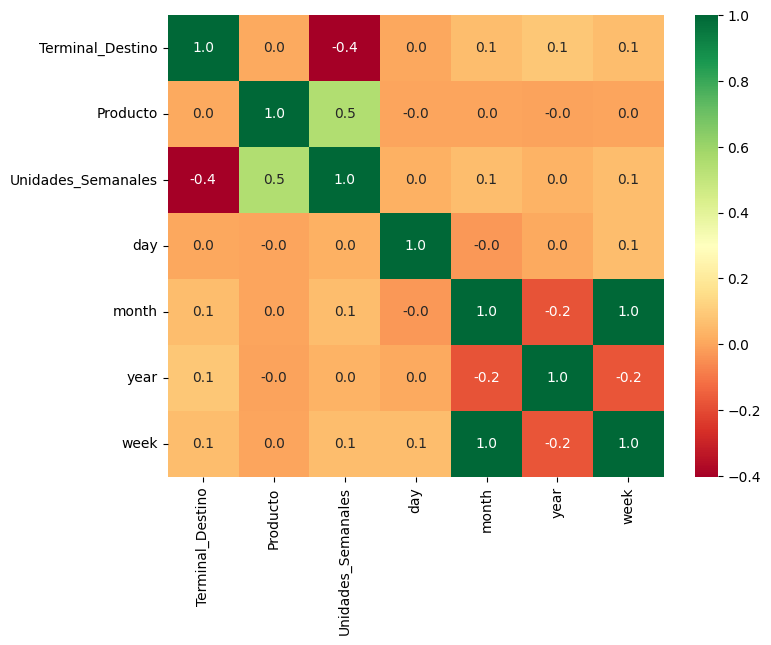

In [30]:
plt.figure(figsize=(8, 6))  
sns.heatmap(
    df_sem.select_dtypes(include=['number']).corr(),
    annot=True,
    fmt=".1f",         # Un decimal en las anotaciones
    cmap='RdYlGn',
    cbar=True 
)
plt.show()

Perfecto, hay correlaciones. Tanto los productos como la terminal de destino están correlacionados positivamente y negativamente con la variable objetivo (unidades semanales).

Veamos qué obtenemos si entrenamos los modelos, respetando las secuencias de los datos y extrayendo los últimos registros de cada serie temporal.

In [31]:
df = df_sem_prophet.sort_values(
    ["Terminal_Destino", "Producto", "Semana_Viernes"]
).reset_index(drop=True)
df["year"] = df["Semana_Viernes"].dt.year
df["month"] = df["Semana_Viernes"].dt.month
df["week"] = df["Semana_Viernes"].dt.isocalendar().week.astype(int)
df["day"] = df["Semana_Viernes"].dt.day
df["dow"] = df["Semana_Viernes"].dt.dayofweek

cod_terminal = {
    terminal: int(terminal.split('.')[0])
    for terminal in df['Terminal_Destino']
}
df['Terminal_Destino'] =df['Terminal_Destino'].map(cod_terminal)
df.head()

,Terminal_Destino,Producto,Semana_Viernes,Unidades_Semanales,year,month,week,day,dow
0,11,1,2024-01-05,1,2024,1,1,5,4
1,11,1,2024-01-12,8,2024,1,2,12,4
2,11,1,2024-01-19,10,2024,1,3,19,4
3,11,1,2024-01-26,12,2024,1,4,26,4
4,11,1,2024-02-02,14,2024,2,5,2,4


Conservaremos los últimos seis registros de cada serie temporal para los datos de prueba.

In [32]:
n_test = 6
test = (
    df.sort_values(["Terminal_Destino", "Producto", "Semana_Viernes"])
      .groupby(["Terminal_Destino", "Producto"])
      .tail(n_test)
      .reset_index(drop=True)
)

train = (
    df.merge(
        test[["Terminal_Destino", "Producto", "Semana_Viernes"]],
        on=["Terminal_Destino", "Producto", "Semana_Viernes"],
        how="left",
        indicator=True
    )
    .query('_merge == "left_only"')
    .drop(columns="_merge")
    .reset_index(drop=True)
)


In [33]:
X_train = train.drop(columns=["Unidades_Semanales", "Semana_Viernes"])
y_train = train["Unidades_Semanales"]

X_test  = test.drop(columns=["Unidades_Semanales", "Semana_Viernes"])
y_test  = test["Unidades_Semanales"]


In [34]:

def model(y_test, y_train, X_test, X_train, model):
    model_instance = model()
    model_instance.fit(X_train, y_train)
    y_pred = model_instance.predict(X_test)

    # ---- MÉTRICAS ----
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred) * 100
    mask = (y_test != 0) & (~np.isnan(y_test))
    if mask.sum() > 0:
        mape = mean_absolute_percentage_error(y_test[mask], y_pred[mask])
    else:
        mape = np.nan
    print('-----------------')
    print(model.__name__)
    print('-----------------')
    print(f'MSE : {mse}')
    print(f'MAE : {mae}')
    print(f'R2  : {round(r2, 2)} %')
    if not np.isnan(mape):
        print(f'MAPE: {mape:.4f}')
    else:
        print("MAPE: No disponible (valores reales = 0)")
    return model_instance
x = [model(y_test, y_train, X_test, X_train, i) for i in [
    RandomForestRegressor,
    GradientBoostingRegressor,
    XGBRegressor
]]


-----------------
RandomForestRegressor
-----------------
MSE : 223213.99283697322
MAE : 247.0946551724138
R2  : 77.64 %
MAPE: 0.8462
-----------------
GradientBoostingRegressor
-----------------
MSE : 231397.94498101412
MAE : 303.39753804667487
R2  : 76.82 %
MAPE: 2.0648
-----------------
XGBRegressor
-----------------
MSE : 196294.15625
MAE : 234.03717041015625
R2  : 80.34 %
MAPE: 1.2140


Excelente. XGBRegressor tiene un R² de 80.3%, indicando que puede explicar casi el 80% de la variabilidad de los datos.

Procedamos ahora a evaluar el desempeño del modelo Prophet.

## Prophet

Prophet es un framework de forecasting (pronóstico de series de tiempo) desarrollado por Facebook (Meta) que se lanzó en 2017. Está diseñado específicamente para series de tiempo con fuertes patrones estacionales. Veamos si es capas de obtener mejores resultados.

In [35]:
# Configurar estilo de gráficos
plt.style.use('default')
sns.set_palette("husl")

# -----------------------------------------------------------
# 0. Helpers / Config global 
# -----------------------------------------------------------
# Parámetros de tuning por defecto
DEFAULT_PARAM_GRID = {
    'changepoint_prior_scale': [0.01, 0.1, 0.3,0.5],
    'seasonality_prior_scale': [0.1, 1.0,4.0 ,10.0]
}

# Horizon para CV 
CV_HORIZON = '6 weeks' # Indica cuánto tiempo hacia adelante se evaluará cada modelo.
CV_PERIOD = '4 weeks'  # Cada 4 semanas se hace una nueva partición.
CV_INITIAL = '30 weeks' # Esto significa que el primer modelo solo entrena con 30 semanas

# -----------------------------------------------------------
# Función de Tuning para Prophet por serie
# -----------------------------------------------------------
def prophet_tuning(df_train: pd.DataFrame, param_grid: dict = None):
    """
    Ejecuta un grid search simple sobre Prophet.
    Intenta usar cross_validation; si falla (series cortas), hace un holdout interno.
    Devuelve los mejores parámetros como dict o None si falla.
    """
    if param_grid is None:
        param_grid = DEFAULT_PARAM_GRID

    # crear combinaciones
    params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
    results = []

    # Número de observaciones en train
    n_train = df_train.shape[0]

    for param in params:
        try:
            # Intentar validar con cross_validation (siempre que haya suficiente data)
            m = Prophet(
                changepoint_prior_scale=param['changepoint_prior_scale'],
                seasonality_prior_scale=param['seasonality_prior_scale'],
                yearly_seasonality=False,
                weekly_seasonality=True,
                daily_seasonality=False,
                interval_width=0.95
            )
            m.fit(df_train)

            # Solo intentar cross_validation si la serie tiene al menos 2 * initial observations
            # cross_validation puede lanzar si initial/horizon no son apropiados
            try:
                df_cv = cross_validation(m, horizon=CV_HORIZON, period=CV_PERIOD, initial=CV_INITIAL)
                df_p = performance_metrics(df_cv, rolling_window=1)
                mse = df_p['mse'].mean() if 'mse' in df_p.columns else np.inf
            except Exception:
                # Fallback: holdout dentro de df_train (usar último 12 semanas como validación, si existe)
                if n_train >= 6:
                    val_size = min(12, max(1, int(0.2 * n_train)))  # 20% o hasta 12
                    train_inner = df_train.iloc[:-val_size]
                    val_inner = df_train.iloc[-val_size:]
                    m_inner = Prophet(
                        changepoint_prior_scale=param['changepoint_prior_scale'],
                        seasonality_prior_scale=param['seasonality_prior_scale'],
                        yearly_seasonality=False,
                        weekly_seasonality=True,
                        daily_seasonality=False,
                        interval_width=0.95
                    )
                    m_inner.fit(train_inner)
                    pred_val = m_inner.predict(val_inner)
                    y_true = val_inner['y'].values
                    y_pred = pred_val['yhat'].values
                    # limpiar NaNs
                    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
                    if mask.sum() == 0:
                        mse = np.inf
                    else:
                        mse = mean_squared_error(y_true[mask], y_pred[mask])
                else:
                    # Si la serie es extremadamente corta, no podemos evaluar bien
                    mse = np.inf

            results.append((param, mse))

        except Exception as e:
            # Cualquier error: marcar con infinito para que no sea elegido
            results.append((param, np.inf))

    # seleccionar mejor (menor MSE)
    # si todos son inf, devolvemos None
    results_sorted = sorted(results, key=lambda x: x[1])
    if len(results_sorted) == 0 or results_sorted[0][1] == np.inf:
        return None
    best_param = results_sorted[0][0]
    return best_param

# -----------------------------------------------------------
# 1. Preparar datos por Terminal–Producto
# -----------------------------------------------------------
def prep_store_data(df: pd.DataFrame,
                    Terminal_Destino: object,
                    Producto: int):

    # FILTRADO CORRECTO (usando df, NO variables globales)
    df_f = df[
        (df['Terminal_Destino'] == Terminal_Destino) &
        (df['Producto'] == Producto)
    ].copy()

    # Asegurar tipos
    df_f['Semana_Viernes'] = pd.to_datetime(df_f['Semana_Viernes'])

    df_f.rename(columns={
        'Semana_Viernes': 'ds',
        'Unidades_Semanales': 'y'
    }, inplace=True)

    df_f = df_f.sort_values('ds')

    return df_f.reset_index(drop=True)

# -----------------------------------------------------------
# 2. Entrenar Prophet y evaluar (ahora con tuning)
# -----------------------------------------------------------
def train_predict(df: pd.DataFrame,
                  train_fraction: float,
                  seasonality: dict,
                  Terminal_Destino: object,
                  Producto: int,
                  param_grid: dict = None):
    """
    Devuelve:
     predicted, df_train, df_test, train_index, metrics_tuple, (Terminal,Producto), best_params
    """

    # VALIDACIÓN IMPORTANTE
    if df.shape[0] < 5:
        print(f"Serie demasiado corta: Terminal={Terminal_Destino}, Producto={Producto}, registros={df.shape[0]}")
        return None, None, None, None, None, (Terminal_Destino, Producto), None

    train_index = int(train_fraction * df.shape[0])
    df_train = df.iloc[:train_index].copy()
    df_test = df.iloc[train_index:].copy()

    # Prophet requiere al menos 2 puntos en train
    if df_train.shape[0] < 2:
        print(f"Train demasiado pequeño: Terminal={Terminal_Destino}, Producto={Producto}")
        return None, None, None, None, None, (Terminal_Destino, Producto), None

    # ------------ TUNING -------------
    best_params = prophet_tuning(df_train, param_grid=param_grid)
    if best_params is None:
        # si no se encontró, usar valores por defecto razonables
        best_params = {
            'changepoint_prior_scale': 0.1,
            'seasonality_prior_scale': 1.0
        }

    # -------------------------------------------------------
    # 2. Entrenar modelo final con mejores hiperparámetros
    # -------------------------------------------------------
    try:
        model = Prophet(
            changepoint_prior_scale=best_params['changepoint_prior_scale'],
            seasonality_prior_scale=best_params['seasonality_prior_scale'],
            yearly_seasonality=seasonality.get('yearly', False),
            weekly_seasonality=seasonality.get('weekly', True),
            daily_seasonality=seasonality.get('daily', False),
            interval_width=0.95
        )

        model.fit(df_train)
        predicted = model.predict(df_test)

    except Exception as e:
        print(f"Error entrenando modelo final Terminal={Terminal_Destino}, Producto={Producto}: {e}")
        return None, df_train, df_test, train_index, None, (Terminal_Destino, Producto), best_params

    # Calcular métricas
    y_true = df_test['y'].values
    y_pred = predicted['yhat'].values

    # Filtrar valores no nulos para evitar errores en métricas
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]

    if len(y_true_clean) == 0:
        print(f"No hay valores válidos para calcular métricas: Terminal={Terminal_Destino}, Producto={Producto}")
        mae = mse = rmse = mape = None
    else:
        mae = mean_absolute_error(y_true_clean, y_pred_clean)
        mse = mean_squared_error(y_true_clean, y_pred_clean)
        rmse = np.sqrt(mse)

        try:
            mape = mean_absolute_percentage_error(y_true_clean, y_pred_clean)
        except:
            mape = None

    return predicted, df_train, df_test, train_index, (mae, mse, rmse, mape), (Terminal_Destino, Producto), best_params

# -----------------------------------------------------------
# 3. Función para graficar una serie específica
# -----------------------------------------------------------
def plot_series_results(ray_results, terminal_destino, producto, show_components=False):
    """
    Grafica los resultados para una serie específica (Terminal-Producto)
    """
    # Encontrar el índice de la serie específica
    series_index = None
    for i, (terminal, prod) in enumerate(ray_results['identifiers']):
        if terminal == terminal_destino and prod == producto:
            series_index = i
            break

    if series_index is None:
        print(f"No se encontró la serie: Terminal={terminal_destino}, Producto={producto}")
        available_series = list(set(ray_results['identifiers']))
        print(f"Series disponibles: {available_series[:10]}...")  # Mostrar solo las primeras 10
        return

    # Extraer datos para la serie específica
    prediction = ray_results['predictions'][series_index]
    train_data = ray_results['train_data'][series_index]
    test_data = ray_results['test_data'][series_index]
    metrics = ray_results['metrics'][series_index]
    best_params = ray_results.get('best_params', [None]*len(ray_results['predictions']))[series_index]

    if prediction is None or train_data is None:
        print(f"No hay datos válidos para: Terminal={terminal_destino}, Producto={producto}")
        return

    # Crear figura con subplots
    if show_components:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        ax1, ax2, ax3, ax4 = axes.flatten()
    else:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Gráfico 1: Serie completa con predicciones
    ax1.plot(train_data['ds'], train_data['y'], 'bo-', label='Entrenamiento', markersize=4, linewidth=1)
    ax1.plot(test_data['ds'], test_data['y'], 'go-', label='Prueba Real', markersize=4, linewidth=1)
    ax1.plot(test_data['ds'], prediction['yhat'], 'r-', label='Predicción', linewidth=2)
    if 'yhat_lower' in prediction.columns and 'yhat_upper' in prediction.columns:
        ax1.fill_between(test_data['ds'],
                        prediction['yhat_lower'],
                        prediction['yhat_upper'],
                        alpha=0.3, label='Intervalo 95%')

    ax1.set_title(f'Predicción Prophet - Terminal: {terminal_destino}, Producto: {producto}', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Fecha')
    ax1.set_ylabel('Unidades Semanales')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Gráfico 2: Zoom en el período de prueba
    ax2.plot(test_data['ds'], test_data['y'], 'go-', label='Real', markersize=6, linewidth=2)
    ax2.plot(test_data['ds'], prediction['yhat'], 'ro-', label='Predicción', markersize=4, linewidth=2)
    if 'yhat_lower' in prediction.columns and 'yhat_upper' in prediction.columns:
        ax2.fill_between(test_data['ds'],
                        prediction['yhat_lower'],
                        prediction['yhat_upper'],
                        alpha=0.3, label='Intervalo 95%')

    # Mostrar métricas y params en el gráfico
    metric_texts = []
    if metrics and all(m is not None for m in metrics):
        mae, mse, rmse, mape = metrics
        metric_texts.append(f'MAE: {mae:.2f}')
        metric_texts.append(f'RMSE: {rmse:.2f}')
        if mape is not None:
            metric_texts.append(f'MAPE: {mape:.2%}')
    if best_params is not None:
        metric_texts.append(f"cps: {best_params.get('changepoint_prior_scale')}, sps: {best_params.get('seasonality_prior_scale')}")

    if len(metric_texts) > 0:
        ax2.text(0.02, 0.98, "\n".join(metric_texts), transform=ax2.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontsize=10)

    ax2.set_title('Período de Prueba - Predicción vs Real', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Fecha')
    ax2.set_ylabel('Unidades Semanales')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Componentes de Prophet (si se solicita)
    if show_components and hasattr(prediction, 'columns'):
        # Tendencia
        if 'trend' in prediction.columns:
            ax3.plot(prediction['ds'], prediction['trend'], 'b-', linewidth=2)
            ax3.set_title('Componente de Tendencia')
            ax3.set_xlabel('Fecha')
            ax3.set_ylabel('Tendencia')
            ax3.grid(True, alpha=0.3)

        # Estacionalidad (si existe)
        if 'weekly' in prediction.columns:
            ax4.plot(prediction['ds'], prediction['weekly'], 'g-', linewidth=2)
            ax4.set_title('Componente Estacional Semanal')
            ax4.set_xlabel('Fecha')
            ax4.set_ylabel('Estacionalidad')
            ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Imprimir métricas en consola
    if metrics and all(m is not None for m in metrics):
        mae, mse, rmse, mape = metrics
        print(f"MÉTRICAS - Terminal: {terminal_destino}, Producto: {producto}")
        print(f"MAE: {mae:.2f}")
        print(f"MSE: {mse:.2f}")
        print(f"RMSE: {rmse:.2f}")
        if mape is not None:
            print(f"MAPE: {mape:.2%}")
    if best_params is not None:
        print(f"Mejores hiperparámetros: {best_params}")

# -----------------------------------------------------------
# 4. Función para analizar resultados
# -----------------------------------------------------------
def analyze_results(ray_results):
    """Analiza los resultados y calcula métricas agregadas"""
    metrics_list = []
    valid_models = 0
    best_params_list = ray_results.get('best_params', [None]*len(ray_results['predictions']))

    for i, metrics in enumerate(ray_results['metrics']):
        terminal, producto = ray_results['identifiers'][i]
        best_params = best_params_list[i] if i < len(best_params_list) else None

        if metrics is not None and all(m is not None for m in metrics):
            mae, mse, rmse, mape = metrics

            metrics_list.append({
                'Terminal_Destino': terminal,
                'Producto': producto,
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse,
                'MAPE': mape,
                'best_params': best_params
            })
            valid_models += 1
        else:
            
            metrics_list.append({
                'Terminal_Destino': terminal,
                'Producto': producto,
                'MAE': None,
                'MSE': None,
                'RMSE': None,
                'MAPE': None,
                'best_params': best_params
            })

    # Crear DataFrame con métricas
    metrics_df = pd.DataFrame(metrics_list)

    print(f"RESUMEN DE MÉTRICAS:")
    print(f"Modelos válidos: {valid_models}/{len(ray_results['metrics'])}")

    if len(metrics_df) > 0 and metrics_df['MAE'].notnull().sum() > 0:
        print(f"\n Métricas Promedio (solo válidos):")
        valid_df = metrics_df[metrics_df['MAE'].notnull()]
        print(f"MAE: {valid_df['MAE'].mean():.2f}")
        print(f"MSE: {valid_df['MSE'].mean():.2f}")
        print(f"RMSE: {valid_df['RMSE'].mean():.2f}")
        print(f"MAPE: {valid_df['MAPE'].mean():.2%}")

        print(f"\n Mejores modelos por MAE:")
        best_mae = valid_df.nsmallest(5, 'MAE')
        for _, row in best_mae.iterrows():
            print(f"  Terminal {row['Terminal_Destino']}, Producto {row['Producto']}: MAE={row['MAE']:.2f}, params={row['best_params']}")

    return metrics_df

# -----------------------------------------------------------
# 5. Función para listar series disponibles
# -----------------------------------------------------------
def list_available_series(ray_results, max_display=10):
    """Lista las series disponibles en los resultados"""
    available_series = list(set(ray_results['identifiers']))
    available_series = [s for s in available_series if s is not None]

    print(f"Series disponibles ({len(available_series)}):")
    for i, (terminal, producto) in enumerate(available_series[:max_display]):
        print(f"  {i+1}. Terminal: {terminal}, Producto: {producto}")

    if len(available_series) > max_display:
        print(f"  ... y {len(available_series) - max_display} más")

    return available_series

# -----------------------------------------------------------
# 6. Función remota con Ray 
# -----------------------------------------------------------
@ray.remote(num_returns=7)
def prep_train_predict(df: pd.DataFrame,
                       Terminal_Destino: object,
                       Producto: int,
                       train_fraction: float = 0.8,
                       seasonality: dict = {'yearly': True, 'weekly': True, 'daily': False},
                       param_grid: dict = None):

    df_f = prep_store_data(df, Terminal_Destino, Producto)
    return train_predict(df_f, train_fraction, seasonality, Terminal_Destino, Producto, param_grid=param_grid)

# -----------------------------------------------------------
# 7. Ejecución principal
# -----------------------------------------------------------
def run_all(df_sem_prophet,
            train_fraction: float = 0.8,
            seasonality: dict = {'yearly': True, 'weekly': True, 'daily': False},
            param_grid: dict = None,
            num_cpus: int = 4):

    terminales = df_sem_prophet['Terminal_Destino'].unique()
    productos = df_sem_prophet['Producto'].unique()

    print(f"Iniciando procesamiento de {len(terminales)} terminales y {len(productos)} productos...")

    ray.init(num_cpus=num_cpus, ignore_reinit_error=True)
    df_id = ray.put(df_sem_prophet)

    tasks = []
    for t in terminales:
        for p in productos:
            tasks.append(prep_train_predict.remote(df_id, t, p, train_fraction, seasonality, param_grid))

    # desempaquetar
    preds_refs, trains_refs, tests_refs, idx_refs, metrics_refs, id_refs, best_params_refs = map(list, zip(*tasks))

    ray_results = {
        'predictions': ray.get(preds_refs),
        'train_data': ray.get(trains_refs),
        'test_data': ray.get(tests_refs),
        'train_indices': ray.get(idx_refs),
        'metrics': ray.get(metrics_refs),
        'identifiers': ray.get(id_refs),
        'best_params': ray.get(best_params_refs)
    }

    # Analizar resultados generales
    metrics_df = analyze_results(ray_results)

    # Listar series disponibles
    available_series = list_available_series(ray_results)

    # Cerrar Ray
    ray.shutdown()

    return ray_results, metrics_df



In [36]:

ray_results, metrics_df = run_all(df_sem_prophet,
                                   train_fraction=0.8,
                                   seasonality={'yearly': True, 'weekly': True, 'daily': False},
                                   param_grid=DEFAULT_PARAM_GRID,
                                   num_cpus=4)

Iniciando procesamiento de 29 terminales y 3 productos...


2025-11-17 22:43:58,805	INFO worker.py:2012 -- Started a local Ray instance.
(prep_train_predict pid=957858) 22:44:00 - cmdstanpy - INFO - Chain [1] start processing
(prep_train_predict pid=957858) 22:44:00 - cmdstanpy - INFO - Chain [1] done processing
(prep_train_predict pid=957860) 22:44:05 - cmdstanpy - INFO - Chain [1] start processing [repeated 108x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(prep_train_predict pid=957859) 22:44:05 - cmdstanpy - INFO - Chain [1] done processing [repeated 106x across cluster]
(prep_train_predict pid=957857) 22:44:10 - cmdstanpy - INFO - Chain [1] start processing [repeated 111x across cluster]
(prep_train_predict pid=957857) 22:44:10 - cmdstanpy - INFO - Chain [1] done processing [repeated 111x across cluster]
(prep_train_predict pid=957857) 22:44:15 - cmdstanpy - 

RESUMEN DE MÉTRICAS:
Modelos válidos: 87/87

 Métricas Promedio (solo válidos):
MAE: 226.61
MSE: 163048.75
RMSE: 290.65
MAPE: 53.84%

 Mejores modelos por MAE:
  Terminal 37. Fusagasuga, Producto 1: MAE=2.71, params={'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0}
  Terminal 36. Riohacha, Producto 1: MAE=5.48, params={'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}
  Terminal 34. Florencia, Producto 1: MAE=5.78, params={'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}
  Terminal 15. Buenaventura, Producto 1: MAE=7.48, params={'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}
  Terminal 38. La Ceja, Producto 1: MAE=8.13, params={'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 4.0}
Series disponibles (87):
  1. Terminal: 8. Sincelejo, Producto: 1
  2. Terminal: 11. Pasto, Producto: 2
  3. Terminal: 4. Pereira, Producto: 2
  4. Terminal: 8. Sincelejo, Producto: 3
  5. Terminal: 6. Bucaramanga, Producto: 1
  6. Termin

(prep_train_predict pid=957857) 22:46:20 - cmdstanpy - INFO - Chain [1] start processing [repeated 28x across cluster]
(prep_train_predict pid=957857) 22:46:20 - cmdstanpy - INFO - Chain [1] done processing [repeated 31x across cluster]


Analicemos cómo son las predicciones de los modelos Prophet.

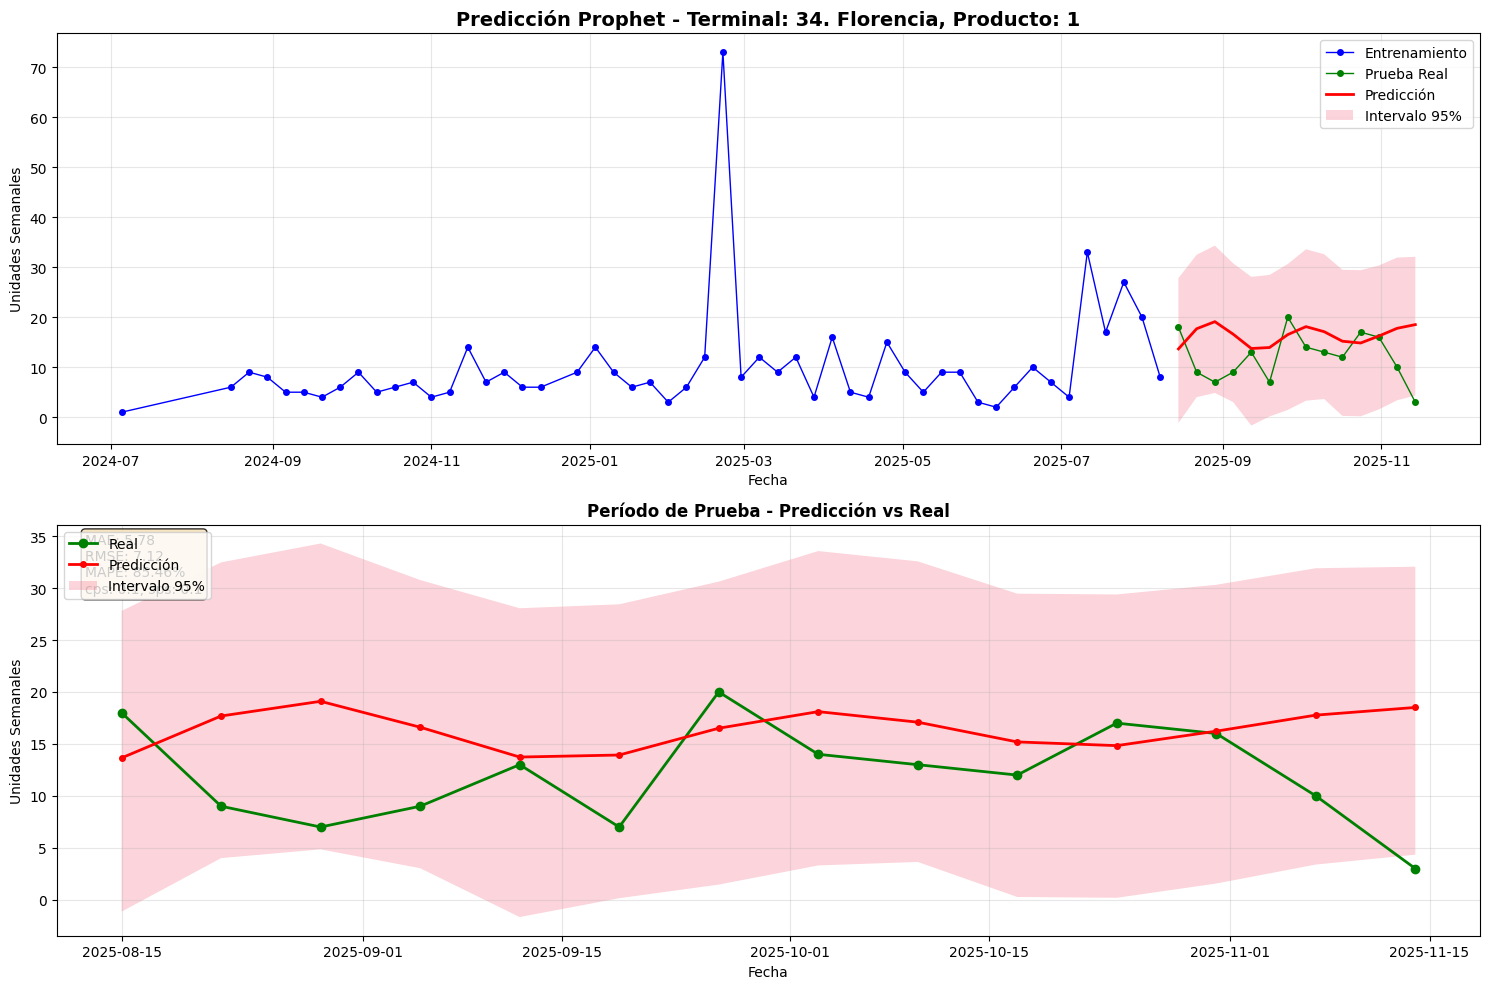

MÉTRICAS - Terminal: 34. Florencia, Producto: 1
MAE: 5.78
MSE: 50.63
RMSE: 7.12
MAPE: 85.46%
Mejores hiperparámetros: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


In [37]:

plot_series_results(ray_results, terminal_destino='34. Florencia', producto=1, show_components=False)


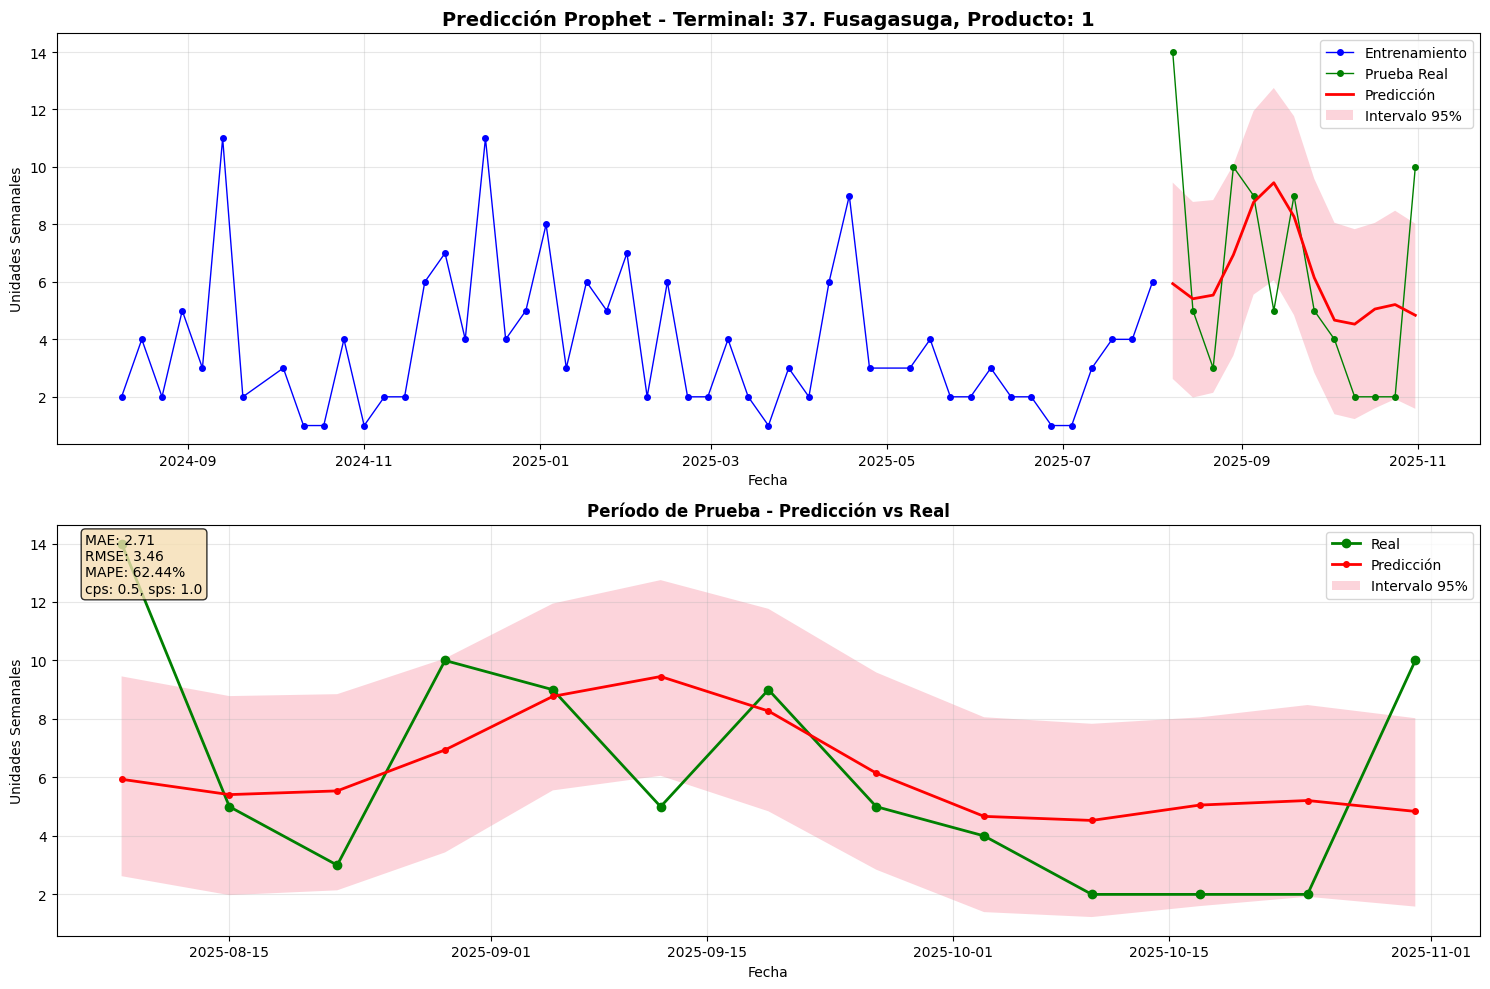

MÉTRICAS - Terminal: 37. Fusagasuga, Producto: 1
MAE: 2.71
MSE: 11.99
RMSE: 3.46
MAPE: 62.44%
Mejores hiperparámetros: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0}


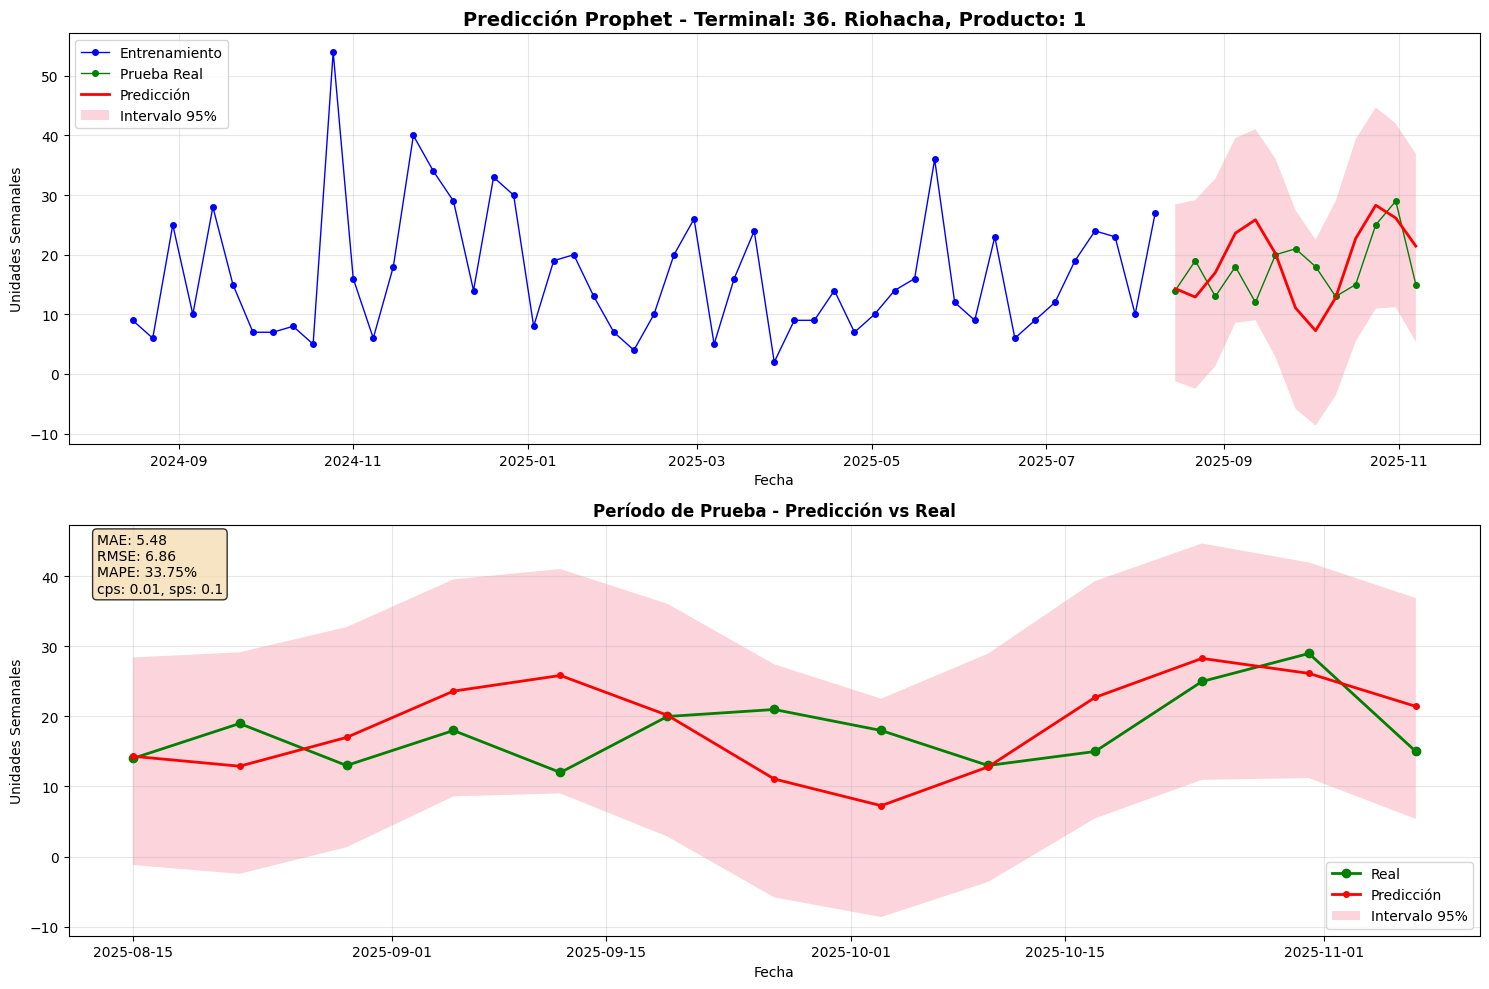

MÉTRICAS - Terminal: 36. Riohacha, Producto: 1
MAE: 5.48
MSE: 47.02
RMSE: 6.86
MAPE: 33.75%
Mejores hiperparámetros: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


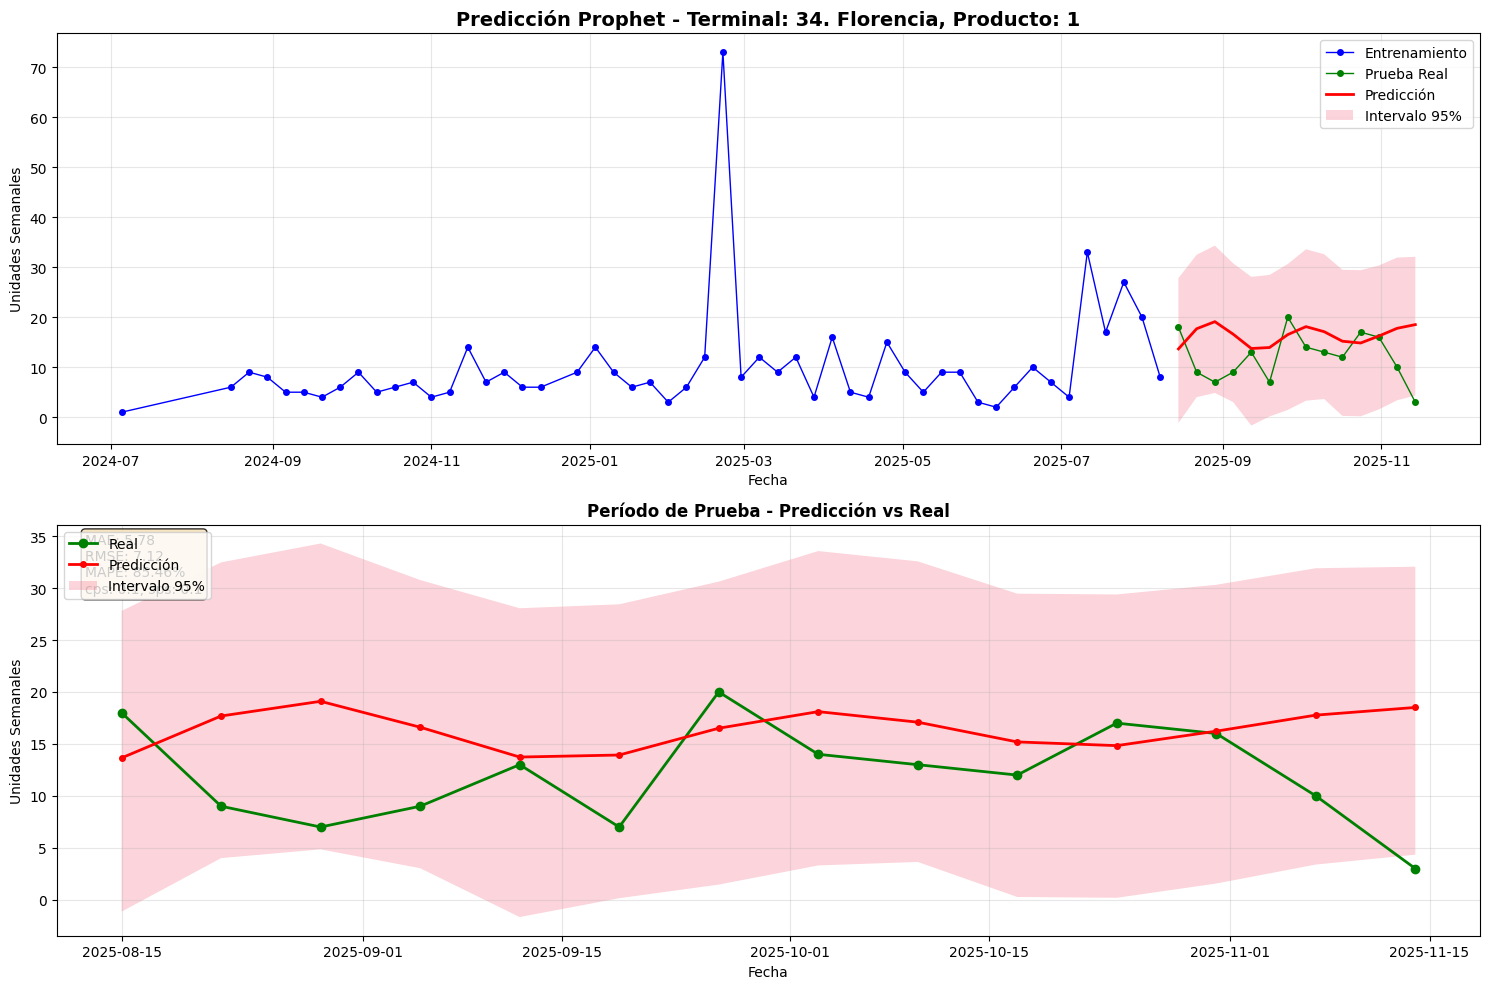

MÉTRICAS - Terminal: 34. Florencia, Producto: 1
MAE: 5.78
MSE: 50.63
RMSE: 7.12
MAPE: 85.46%
Mejores hiperparámetros: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


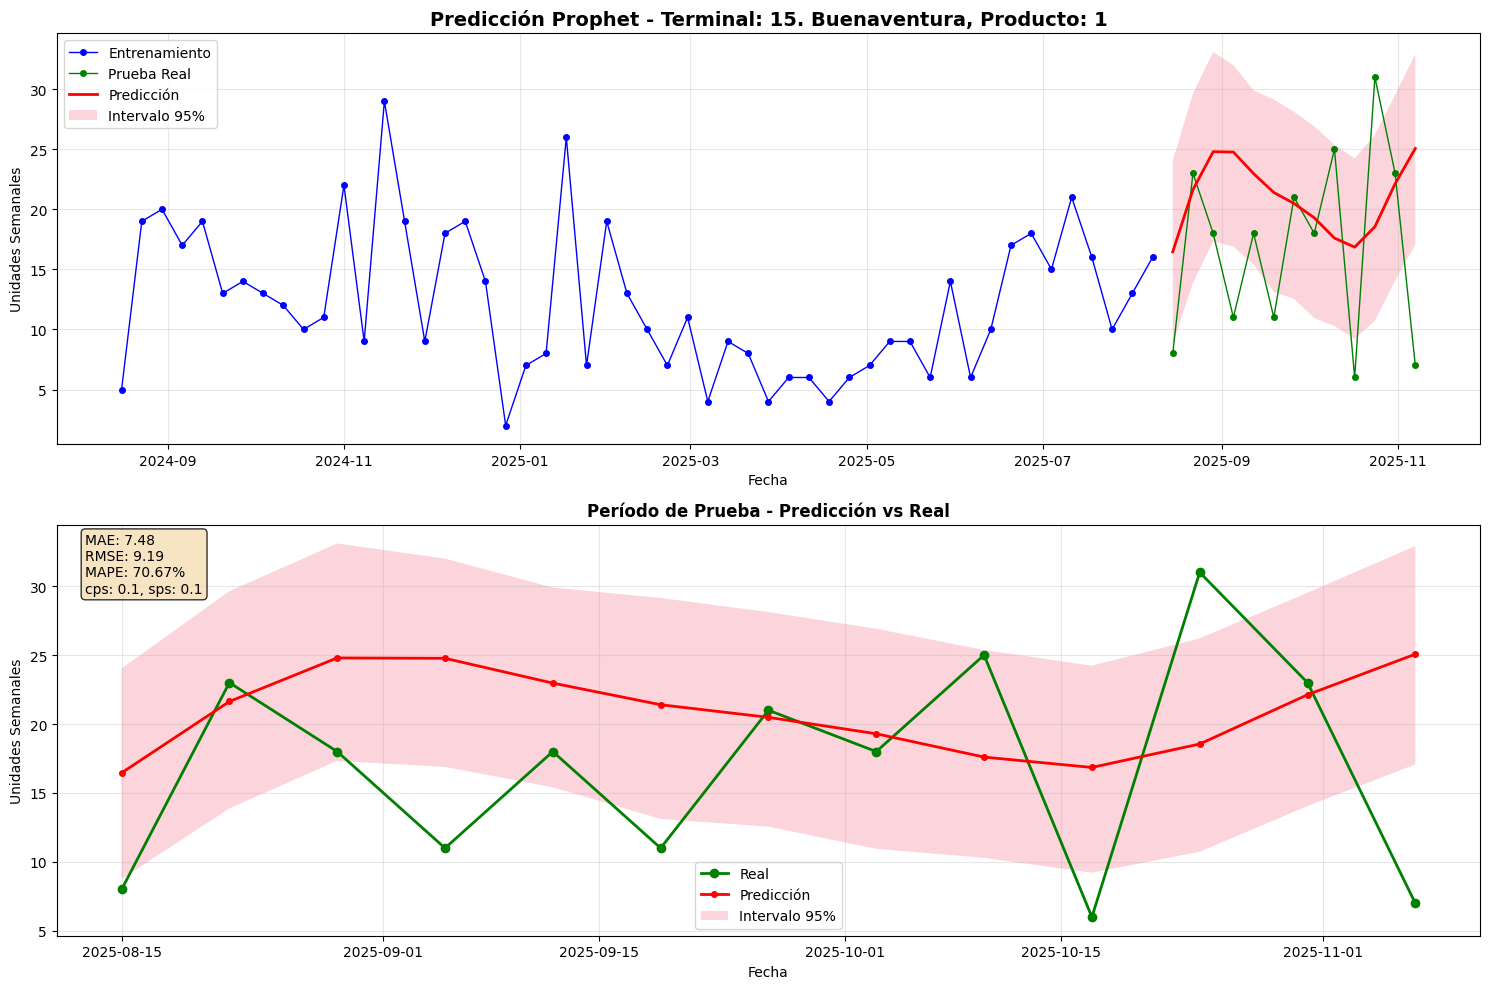

MÉTRICAS - Terminal: 15. Buenaventura, Producto: 1
MAE: 7.48
MSE: 84.48
RMSE: 9.19
MAPE: 70.67%
Mejores hiperparámetros: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


In [38]:
best_series = metrics_df.nsmallest(4, 'MAE')
for _, row in best_series.iterrows():
    plot_series_results(ray_results, row['Terminal_Destino'], row['Producto'])

Está claro que implementar modelos específicos para series de tiempo puede complicar el proceso, especialmente considerando que nuestras series son bastante cortas. Con tan pocos datos, es probable que aún no se hayan definido tendencias o patrones de estacionalidad lo suficientemente claros para que estos modelos puedan capturarlos de manera efectiva.

Por esta razón, optaremos por utilizar métodos basados en árboles de decisión.

## hyperparameter-optimization

Durante el entrenamiento de los modelos con sus configuraciones por defecto, observamos que XGBRegressor lograró explicar casi el 90% de la variabilidad de los datos de entregas semanales. Sin embargo, exploraremos la posibilidad de optimizar los parámetros de cada modelo y someterlos a una comparación para determinar cuál ofrece el mejor rendimiento y predicciones.

La optimización de hiperparámetros se realizará utilizando **Optuna**, una herramienta diseñada para minimizar o maximizar una función objetivo. En este caso, la función objetivo a maximizar será el coeficiente de determinación R2. 

### XGBRegressor

In [ ]:
def optimizar_xgb_holdout(trial, df, n_test=6):
    X_train = train.drop(columns=["Unidades_Semanales", "Semana_Viernes"])
    y_train = train["Unidades_Semanales"]

    X_valid = test.drop(columns=["Unidades_Semanales", "Semana_Viernes"])
    y_valid = test["Unidades_Semanales"]

    # Hiperparámetros a buscar
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse'
    }

    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    return r2_score(y_valid, y_pred)


In [51]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: optimizar_xgb_holdout(trial, df), n_trials=150)

[I 2025-11-14 22:03:12,188] A new study created in memory with name: no-name-7177f15d-deea-4cd9-ba01-b0c0271c0f04
[I 2025-11-14 22:03:17,961] Trial 0 finished with value: 0.7511508464813232 and parameters: {'n_estimators': 142, 'learning_rate': 0.11014132562991769, 'max_depth': 3, 'min_child_weight': 14, 'subsample': 0.522658363691028, 'colsample_bytree': 0.5900903599405771, 'gamma': 0.20850195857401055}. Best is trial 0 with value: 0.7511508464813232.
[I 2025-11-14 22:03:18,080] Trial 1 finished with value: 0.8082672357559204 and parameters: {'n_estimators': 94, 'learning_rate': 0.13460583359120917, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.9759348217841615, 'colsample_bytree': 0.5832612044692056, 'gamma': 0.4602127369418566}. Best is trial 1 with value: 0.8082672357559204.
[I 2025-11-14 22:03:18,442] Trial 2 finished with value: 0.8112444877624512 and parameters: {'n_estimators': 233, 'learning_rate': 0.19094977153418405, 'max_depth': 8, 'min_child_weight': 20, 'subsample

In [53]:
print(study.best_params)
print(study.best_value)

{'n_estimators': 50, 'learning_rate': 0.23118854036040393, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.6496335936352312, 'colsample_bytree': 0.6045116134311034, 'gamma': 0.5523292363577992}
0.8428341746330261


### RandomForestRegressor

In [54]:
def optimizar_rf_holdout(trial, df, n_test=6):

    X_train = train.drop(columns=["Unidades_Semanales", "Semana_Viernes"])
    y_train = train["Unidades_Semanales"]

    X_valid = test.drop(columns=["Unidades_Semanales", "Semana_Viernes"])
    y_valid = test["Unidades_Semanales"]
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 2, 200),
        'max_depth': trial.suggest_int('max_depth', 2, 12),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.8, 1.0]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 5),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'n_jobs': -1,
        'random_state': 42
    }

    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    return r2_score(y_valid, y_pred)


In [55]:
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(lambda trial: optimizar_rf_holdout(trial, df), n_trials=100)

[I 2025-11-14 22:06:31,895] A new study created in memory with name: no-name-18090fe3-d6fd-4c1f-b20c-721b7336587b
[I 2025-11-14 22:06:32,005] Trial 0 finished with value: 0.7339137568756742 and parameters: {'n_estimators': 77, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 0 with value: 0.7339137568756742.
[I 2025-11-14 22:06:32,096] Trial 1 finished with value: 0.8048032275536273 and parameters: {'n_estimators': 26, 'max_depth': 8, 'max_features': 1.0, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 1 with value: 0.8048032275536273.
[I 2025-11-14 22:06:32,286] Trial 2 finished with value: 0.7934391912208026 and parameters: {'n_estimators': 137, 'max_depth': 8, 'max_features': 0.8, 'min_samples_split': 3, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 1 with value: 0.8048032275536273.
[I 2025-11-14 22:06:32,471] Trial 3 finished with value: 0.7854255986970521 and param

In [56]:
print(study_rf.best_params)
print(study_rf.best_value)

{'n_estimators': 43, 'max_depth': 8, 'max_features': 1.0, 'min_samples_split': 5, 'min_samples_leaf': 4, 'bootstrap': True}
0.8055351985593077


### GradientBoostingRegressor

In [57]:
def optimizar_gbr_holdout(trial, df, n_test=6):
    X_train = train.drop(columns=["Unidades_Semanales", "Semana_Viernes"])
    y_train = train["Unidades_Semanales"]

    X_valid = test.drop(columns=["Unidades_Semanales", "Semana_Viernes"])
    y_valid = test["Unidades_Semanales"]
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 2, 150),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1]),
        'max_depth': trial.suggest_int('max_depth', 2, 12),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 5),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'criterion': trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error']),
        'warm_start': trial.suggest_categorical('warm_start', [True, False]),
        'tol': trial.suggest_float('tol', 0.0001, 0.01),
    }
    model = GradientBoostingRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    return r2_score(y_valid, y_pred)

In [58]:
study_gbr = optuna.create_study(direction="maximize")
study_gbr.optimize(lambda trial: optimizar_gbr_holdout(trial, df), n_trials=100)

[I 2025-11-14 22:07:44,540] A new study created in memory with name: no-name-5a4488c0-c0a7-4815-b9d8-a5ef2017936b
[I 2025-11-14 22:07:44,729] Trial 0 finished with value: 0.8048369410243341 and parameters: {'n_estimators': 20, 'learning_rate': 0.1, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 5, 'subsample': 0.7161946804902913, 'criterion': 'friedman_mse', 'warm_start': False, 'tol': 0.005278318825455752}. Best is trial 0 with value: 0.8048369410243341.
[I 2025-11-14 22:07:44,821] Trial 1 finished with value: 0.6539653226466186 and parameters: {'n_estimators': 44, 'learning_rate': 0.1, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 3, 'subsample': 0.7772147762145696, 'criterion': 'friedman_mse', 'warm_start': False, 'tol': 0.0076900729319917}. Best is trial 0 with value: 0.8048369410243341.
[I 2025-11-14 22:07:44,865] Trial 2 finished with value: 0.4770512688115489 and parameters: {'n_estimators': 12, 'learning_rate': 0.05, 'max_depth': 4, 'min_samples_spli

In [59]:
print(study_gbr.best_params)
print(study_gbr.best_value)

{'n_estimators': 44, 'learning_rate': 0.05, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 3, 'subsample': 0.8479981767182183, 'criterion': 'friedman_mse', 'warm_start': False, 'tol': 0.00995412796449446}
0.8165380746843601


## Compentencia entre modelos

Con los parámetros óptimos encontrados para cada modelo, evaluaremos su desempeño. 

In [39]:
def evaluar_modelo(modelo, df, n_test=6):
    X_train = train.drop(columns=["Unidades_Semanales", "Semana_Viernes"])
    y_train = train["Unidades_Semanales"]

    X_valid = test.drop(columns=["Unidades_Semanales", "Semana_Viernes"])
    y_valid = test["Unidades_Semanales"]
    modelo.fit(X_train, y_train)

    y_pred = modelo.predict(X_valid)

    return {
        "r2": r2_score(y_valid, y_pred),
        "mae": mean_absolute_error(y_valid, y_pred),
        "y_real": y_valid.values,
        "y_pred": y_pred
    }

In [40]:
params_xgb = {'n_estimators': 50, 
              'learning_rate': 0.23118854036040393, 
              'max_depth': 7, 
              'min_child_weight': 6, 
              'subsample': 0.6496335936352312, 
              'colsample_bytree': 0.6045116134311034, 
              'gamma': 0.5523292363577992}

params_RandomForest = {'n_estimators': 43, 
                       'max_depth': 8, 
                       'max_features': 1.0, 
                       'min_samples_split': 5, 
                       'min_samples_leaf': 4, 
                       'bootstrap': True}

params_Gradient = {'n_estimators': 44, 
                   'learning_rate': 0.05, 
                   'max_depth': 8, 
                   'min_samples_split': 4, 
                   'min_samples_leaf': 3, 
                   'subsample': 0.8479981767182183, 
                   'criterion': 'friedman_mse', 
                   'warm_start': False, 
                   'tol': 0.00995412796449446}

In [41]:
xgb = XGBRegressor(**params_xgb)
forest = RandomForestRegressor(**params_RandomForest)
gradient = GradientBoostingRegressor(**params_Gradient)

resultados = {}

resultados["XGBoost"] = evaluar_modelo(xgb, df)
resultados["RandomForest"] = evaluar_modelo(forest, df)
resultados["GradientBoosting"] = evaluar_modelo(gradient, df)

In [42]:
def ver_resultados(resultados):
    resultados_df = pd.DataFrame(resultados).T
    # Iterar sobre cada columna del DataFrame
    for col in resultados_df:
        resultados_df[col] = resultados_df[col].apply(np.mean)
        resultados_df[col + "_idx"] = resultados_df[col] / resultados_df[col].max()
    return resultados_df

In [43]:
tabla_final = ver_resultados(resultados)
tabla_final

,r2,mae,y_real,y_pred,r2_idx,mae_idx,y_real_idx,y_pred_idx
XGBoost,0.84,218.84,828.89,908.62,1.00,0.86,1.00,1.00
RandomForest,0.80,234.02,828.89,890.67,0.95,0.92,1.00,0.98
GradientBoosting,0.81,253.57,828.89,910.03,0.97,1.00,1.00,1.00


Podemos observar que XGBRegressor es el mejor modelo.

## Feature importance

Ya hemos identificado el mejor modelo, pero, ¿cuáles son las características que este considera más importantes?

Para dar respuesta a esta pregunta, vamos a entrenar el modelo con los mejores parámetros encontrados en la validación cruzada y veamos la importancia de características.

In [44]:
def seleccionar_features_con_rfe(df, params_xgb, n_test=6, n_features=4):

    X_train = train.drop(columns=["Unidades_Semanales", "Semana_Viernes"])
    y_train = train["Unidades_Semanales"]

    modelo = XGBRegressor(**params_xgb)
    modelo.fit(X_train, y_train)

    rfe = RFE(modelo, n_features_to_select=n_features)
    rfe.fit(X_train, y_train)
    selected_features = X_train.columns[rfe.support_]

    return selected_features, rfe

In [45]:
selected_features, rfe_model = seleccionar_features_con_rfe(
    df,
    params_xgb=params_xgb,
    n_test=6,
    n_features=4
)

print("Características seleccionadas:", selected_features)

Características seleccionadas: Index(['Terminal_Destino', 'Producto', 'year', 'week'], dtype='object')


Ok, las características más relevantes son La terminal de destino, el producto, el año y la semana.

# Mejor modelo

Dado que ya contamos con un modelo que explica más del 84% de la variabilidad y hemos identificado sus hiperparámetros óptimos, es momento de entrenarlo utilizando esos valores y obtener las nuevas métricas de evaluación.

In [46]:
X_train = train.drop(columns=["Unidades_Semanales", "Semana_Viernes"])
y_train = train["Unidades_Semanales"]

X_test  = test.drop(columns=["Unidades_Semanales", "Semana_Viernes"])
y_test  = test["Unidades_Semanales"]

def model_fit(X_train, y_train, X_test, y_test, model_class):
    model_instance = model_class()
    model_instance.fit(X_train, y_train)
    y_pred = model_instance.predict(X_test)

    # MÉTRICAS
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred) * 100

    mask = (y_test != 0) & (~np.isnan(y_test))
    mape = mean_absolute_percentage_error(y_test[mask], y_pred[mask]) if mask.sum() > 0 else np.nan

    print('-----------------')
    print(model_class.__name__)
    print('-----------------')
    print(f'MSE : {mse}')
    print(f'MAE : {mae}')
    print(f'R2  : {round(r2, 2)} %')
    print(f'MAPE: {mape if not np.isnan(mape) else "No disponible (valores reales = 0)"}')

    return model_instance


In [47]:
models = [
    lambda: XGBRegressor(**params_xgb)
]
results = [
    model_fit(X_train, y_train, X_test, y_test, m)
    for m in models
]


-----------------
<lambda>
-----------------
MSE : 156897.375
MAE : 218.84222412109375
R2  : 84.28 %
MAPE: 1.296444058418274


Perfecto, pudimos mejorar un poco el modelo XGBRegresor, ahora si veamos las predicciones.

# Predicciones

Ahora evaluaremos el nivel de error del modelo al predecir los datos completos. Para ello, entrenaremos el modelo excluyendo los últimos seis registros de cada serie temporal y luego realizaremos pronósticos sobre toda la serie. Con esto podremos calcular el MAE global de cada serie y estimar sus respectivos intervalos de confianza.

In [48]:
model = XGBRegressor(**params_xgb)
model.fit(X_train, y_train)

independientes = df.drop(columns=["Unidades_Semanales", "Semana_Viernes"])
objetivo =df["Unidades_Semanales"]
df['prediccion'] = model.predict(independientes)

In [49]:
# error absoluto 
df["error"] = df["Unidades_Semanales"] - df["prediccion"]
df["abs_error"] = df["error"].abs()


# Distribución de los errores por serie
quantiles = (
    df.groupby(["Terminal_Destino", "Producto"])["error"]
      .quantile([0.05, 0.95])
      .unstack()
)
quantiles.columns = ["q05_error", "q95_error"]

df = df.merge(
    quantiles,
    on=["Terminal_Destino", "Producto"],
    how="left"
)

df["pred_lower"] = df["prediccion"] + df["q05_error"]
df["pred_upper"] = df["prediccion"] + df["q95_error"]

# Mae
mae_series = (
    df.groupby(["Terminal_Destino", "Producto"])["abs_error"]
      .mean()
      .reset_index()
      .rename(columns={"abs_error": "MAE"})
)

df = df.merge(mae_series, on=["Terminal_Destino", "Producto"], how="left")

In [50]:
def plot_confidence_styled(df, destino, producto):
    
    df_plot = df[
        (df["Terminal_Destino"] == destino) &
        (df["Producto"] == producto)
    ].sort_values("Semana_Viernes")

    mae_value = df_plot["MAE"].iloc[0]  

    fig = go.Figure()

    # --- Banda de confianza ---
    fig.add_trace(go.Scatter(
        x=df_plot["Semana_Viernes"],
        y=df_plot["pred_upper"],
        mode='lines',
        line=dict(width=0),
        showlegend=False
    ))

    fig.add_trace(go.Scatter(
        x=df_plot["Semana_Viernes"],
        y=df_plot["pred_lower"],
        mode='lines',
        fill='tonexty',
        fillcolor='rgba(0, 100, 255, 0.20)',
        line=dict(width=0),
        name='Intervalo de confianza'
    ))

    # --- Predicción ---
    fig.add_trace(go.Scatter(
        x=df_plot["Semana_Viernes"],
        y=df_plot["prediccion"],
        mode='lines',
        name='Predicción',
        line=dict(color='red', width=2, dash='dash')
    ))

    # --- Real ---
    fig.add_trace(go.Scatter(
        x=df_plot["Semana_Viernes"],
        y=df_plot["Unidades_Semanales"],
        mode='lines',
        name='Datos Reales',
        line=dict(color='blue', width=2, dash='solid')
    ))

    # --- Layout estilo mejorado ---
    fig.update_layout(
        title=f"<b>Destino={destino} | Producto={producto} — MAE={mae_value:.2f}</b>",
        title_font=dict(size=20, family='Arial', color='black'),
        xaxis_title="<b>Fecha</b>",
        yaxis_title="<b>Unidades</b>",
        font=dict(family='Arial', size=12, color='black'),
        plot_bgcolor="white",
        paper_bgcolor="white",
        hovermode="x unified",
        height=450,
        margin=dict(l=50, r=50, b=50, t=80)
    )

    # --- Estilo de ejes ---
    fig.update_xaxes(showgrid=True, gridcolor='lightgray', tickformat='%Y-%m')
    fig.update_yaxes(showgrid=True, gridcolor='lightgray')

    return fig


In [54]:
df.head()

,Terminal_Destino,Producto,Semana_Viernes,Unidades_Semanales,year,month,week,day,dow,prediccion,error,abs_error,q05_error,q95_error,pred_lower,pred_upper,MAE
0,11,1,2024-01-05,1,2024,1,1,5,4,-54.56,55.56,55.56,-227.28,132.99,-281.84,78.43,74.18
1,11,1,2024-01-12,8,2024,1,2,12,4,-96.88,104.88,104.88,-227.28,132.99,-324.16,36.11,74.18
2,11,1,2024-01-19,10,2024,1,3,19,4,26.01,-16.01,16.01,-227.28,132.99,-201.27,159.00,74.18
3,11,1,2024-01-26,12,2024,1,4,26,4,56.08,-44.08,44.08,-227.28,132.99,-171.20,189.07,74.18
4,11,1,2024-02-02,14,2024,2,5,2,4,-5.66,19.66,19.66,-227.28,132.99,-232.95,127.32,74.18


In [66]:
cod_terminal_inverso = {valor: clave for clave, valor in cod_terminal.items()}
dict_producto_inverso = {valor: clave for clave, valor in dict_producto.items()}
df_i = df.copy()
df_i['Terminal_Destino'] = df_i['Terminal_Destino'].map(cod_terminal_inverso)
df_i['Producto'] = df_i['Producto'].map(dict_producto_inverso)


In [69]:
plot_confidence_styled(df_i, destino='20. Valledupar', producto='Paquetería')

In [70]:
plot_confidence_styled(df_i, destino='6. Bucaramanga', producto='Mercancía')

In [72]:
plot_confidence_styled(df_i, destino='6. Bucaramanga', producto='Paquetería')

In [73]:
plot_confidence_styled(df_i, destino='39. Pitalito', producto='Paquetería')

Perfecto. Ahora realicemos la proyección para las últimas 6 semanas. Recuerda que estos son datos que el modelo no ha visto durante su entrenamiento, por lo que representan una prueba real de su capacidad predictiva.

In [74]:
X_test  = test.drop(columns=["Unidades_Semanales", "Semana_Viernes"])
y_test  = test["Unidades_Semanales"]
test.head()

,Terminal_Destino,Producto,Semana_Viernes,Unidades_Semanales,year,month,week,day,dow
0,4,1,2025-10-10,106,2025,10,41,10,4
1,4,1,2025-10-17,135,2025,10,42,17,4
2,4,1,2025-10-24,137,2025,10,43,24,4
3,4,1,2025-10-31,148,2025,10,44,31,4
4,4,1,2025-11-07,87,2025,11,45,7,4


In [75]:
test['prediccion'] = model.predict(X_test)
# error absoluto 
test["error"] = test["Unidades_Semanales"] - test["prediccion"]
test["abs_error"] = test["error"].abs()


# Distribución de los errores por serie
quantiles = (
    test.groupby(["Terminal_Destino", "Producto"])["error"]
      .quantile([0.05, 0.95])
      .unstack()
)
quantiles.columns = ["q05_error", "q95_error"]

test = test.merge(
    quantiles,
    on=["Terminal_Destino", "Producto"],
    how="left"
)

test["pred_lower"] = test["prediccion"] + test["q05_error"]
test["pred_upper"] = test["prediccion"] + test["q95_error"]

# Mae
mae_series = (
    test.groupby(["Terminal_Destino", "Producto"])["abs_error"]
      .mean()
      .reset_index()
      .rename(columns={"abs_error": "MAE"})
)

test = test.merge(mae_series, on=["Terminal_Destino", "Producto"], how="left")

In [79]:
test['Terminal_Destino'] = test['Terminal_Destino'].map(cod_terminal_inverso)
test['Producto'] = test['Producto'].map(dict_producto_inverso)

Veamos algunas predicciones.

In [80]:
plot_confidence_styled(test, destino='15. Buenaventura', producto='Paquetería')

In [81]:
plot_confidence_styled(test, destino='34. Florencia', producto='Paquetería')

In [82]:
plot_confidence_styled(test, destino='36. Riohacha', producto='Paquetería')